In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T
import random
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from PIL import Image

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.1307, std=0.3081)
])

# Load dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
original_dataset = MNIST(root='./data', train=False, download=False, transform=None) #we'll use it for visualizations later


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.71MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# Pair Dataset with caching for efficiency
class PairDataset(Dataset):
    def __init__(self, dataset, num_pairs=60000):
        self.dataset    = dataset
        self.num_pairs  = num_pairs

        # Build map: label -> [indices…]
        self.labels_hashmap = defaultdict(list)
        for idx, (_, lbl) in enumerate(dataset):
            self.labels_hashmap[lbl].append(idx)

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, _):
        # Pick first image at random
        i1    = random.randrange(len(self.dataset))
        img1, l1 = self.dataset[i1]

        # With probability 0.5 pick same-label, else different-label
        if random.random() < 0.5:
            i2 = random.choice(self.labels_hashmap[l1])
            target = 1.0
        else:
            # choose a label != l1
            l2 = random.choice([lbl for lbl in self.labels_hashmap if lbl != l1])
            i2 = random.choice(self.labels_hashmap[l2])
            target = 0.0

        img2, _ = self.dataset[i2]
        return img1, img2, torch.tensor(target, dtype=torch.float32)

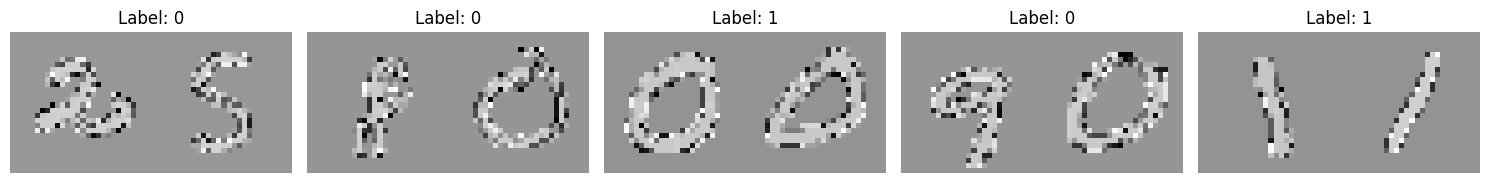

In [3]:
# Pair Dataset Visualization (Horizontal Layout)

# Convert tensor to PIL for display
to_pil = transforms.ToPILImage()

# Load a few sample pairs
num_preview = 5
dataset = PairDataset(train_dataset, num_pairs=5000)

# Prepare data
data = []
for i in range(num_preview):
    img1, img2, label = dataset[i]
    img1_pil = to_pil(img1)
    img2_pil = to_pil(img2)
    data.append({
        'Image 1': img1_pil,
        'Image 2': img2_pil,
        'Label (1=Same, 0=Diff)': int(label.item())
    })

# DataFrame (optional)
df = pd.DataFrame(data)

# Horizontal pair visualization
def show_image_pairs_horizontal(df):
    fig, axs = plt.subplots(1, len(df), figsize=(len(df)*3, 3))  # One row, multiple columns
    for i, row in df.iterrows():
        ax = axs[i] if len(df) > 1 else axs  # handle single row
        combined_img = Image.new('L', (row['Image 1'].width + row['Image 2'].width, row['Image 1'].height))
        combined_img.paste(row['Image 1'], (0, 0))
        combined_img.paste(row['Image 2'], (row['Image 1'].width, 0))
        ax.imshow(combined_img, cmap='gray')
        ax.set_title(f"Label: {row['Label (1=Same, 0=Diff)']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display
show_image_pairs_horizontal(df)

In [44]:
df.head()

,Image 1,Image 2,"Label (1=Same, 0=Diff)"
0,<PIL.Image.Image image mode=L size=28x28 at 0x...,<PIL.Image.Image image mode=L size=28x28 at 0x...,0
1,<PIL.Image.Image image mode=L size=28x28 at 0x...,<PIL.Image.Image image mode=L size=28x28 at 0x...,1
2,<PIL.Image.Image image mode=L size=28x28 at 0x...,<PIL.Image.Image image mode=L size=28x28 at 0x...,1
3,<PIL.Image.Image image mode=L size=28x28 at 0x...,<PIL.Image.Image image mode=L size=28x28 at 0x...,1
4,<PIL.Image.Image image mode=L size=28x28 at 0x...,<PIL.Image.Image image mode=L size=28x28 at 0x...,1


In [4]:
# embedding CNN
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),   # [1, 28, 28] -> [32, 28, 28]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [32, 28, 28] -> [32, 14, 14]

            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # [32, 14, 14] -> [64, 14, 14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [64, 14, 14] -> [64, 7, 7]
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                                 # [64, 7, 7] -> [3136]
            nn.Linear(64 * 7 * 7, 128),                   # [3136] -> [128]
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings to unit length
        return x


class SimilarityModel(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        # Add a projection layer to map similarity to proper range for BCE
        # Input: [B, 1] → Output: [B, 1]
        self.projection = nn.Linear(1, 1)

    def forward(self, img1, img2):
        # img1, img2: [B, 1, 28, 28] (MNIST images)

        # emb1, emb2: [B, 128] (128-dim embedding from embedding_net)
        emb1 = self.embedding_net(img1)
        emb2 = self.embedding_net(img2)

        # sim: [B] (cosine similarity per pair, range [-1, 1])
        sim = F.cosine_similarity(emb1, emb2)

        # sim.unsqueeze(1): [B, 1] to match projection layer input
        # self.projection(sim): [B, 1]
        # squeeze(1): back to [B] for BCE loss compatibility
        return self.projection(sim.unsqueeze(1)).squeeze(1)

    def get_raw_similarity(self, img1, img2):
        """Get raw cosine similarity without projection"""
        # emb1, emb2: [B, 128]
        emb1 = self.embedding_net(img1)
        emb2 = self.embedding_net(img2)

        # Returns cosine similarity in range [-1, 1], shape: [B]
        return F.cosine_similarity(emb1, emb2)


In [5]:
# Evaluation Function
def evaluate(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, labels in data_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)

            outputs = model(img1, img2)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    return avg_loss, accuracy

# Setup device with proper synchronization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss and optimizer
model = SimilarityModel(EmbeddingNet()).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

Training on cuda
Epoch 1/30, Batch 0/79, Loss: 0.7759
Epoch 1/30, Batch 20/79, Loss: 0.5781
Epoch 1/30, Batch 40/79, Loss: 0.5383
Epoch 1/30, Batch 60/79, Loss: 0.4926
Epoch 1/30
  Train Loss: 0.5568
  Test Loss: 0.4674, Accuracy: 0.9582
Model saved!
Epoch 2/30, Batch 0/79, Loss: 0.4656
Epoch 2/30, Batch 20/79, Loss: 0.4446
Epoch 2/30, Batch 40/79, Loss: 0.4022
Epoch 2/30, Batch 60/79, Loss: 0.3703
Epoch 2/30
  Train Loss: 0.4068
  Test Loss: 0.3546, Accuracy: 0.9812
Model saved!
Epoch 3/30, Batch 0/79, Loss: 0.3502
Epoch 3/30, Batch 20/79, Loss: 0.3407
Epoch 3/30, Batch 40/79, Loss: 0.3083
Epoch 3/30, Batch 60/79, Loss: 0.2889
Epoch 3/30
  Train Loss: 0.3144
  Test Loss: 0.2806, Accuracy: 0.9852
Model saved!
Epoch 4/30, Batch 0/79, Loss: 0.2687
Epoch 4/30, Batch 20/79, Loss: 0.2671
Epoch 4/30, Batch 40/79, Loss: 0.2708
Epoch 4/30, Batch 60/79, Loss: 0.2261
Epoch 4/30
  Train Loss: 0.2538
  Test Loss: 0.2247, Accuracy: 0.9882
Model saved!
Epoch 5/30, Batch 0/79, Loss: 0.2271
Epoch 5/30

In [ ]:
# Create data loaders
train_loader = DataLoader(
    PairDataset(train_dataset, num_pairs=20000),
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,  # Keep workers alive between epochs
)

test_loader = DataLoader(
    PairDataset(test_dataset, num_pairs=5000),
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

# Training loop
num_epochs = 30
print(f"Training on {device}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (img1, img2, labels) in enumerate(train_loader):
        img1 = img1.to(device, non_blocking=True)
        img2 = img2.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

        # Use mixed precision for faster training
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    # Evaluate on test set
    val_loss, val_acc = evaluate(model, test_loader, device, criterion)

    # Log results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {total_loss/len(train_loader):.4f}")
    print(f"  Test Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Saving the best model with each epoch
    if epoch == 0 or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved!")
print("Training complete!")

Loaded saved model.
Selected test image with label: 4

Similarity scores for test image (Digit 4):
Similarity to digit 0: 0.0000 (probability: 0.0150)
Similarity to digit 1: 0.0190 (probability: 0.0177)
Similarity to digit 2: 0.0000 (probability: 0.0150)
Similarity to digit 3: 0.0000 (probability: 0.0150)
Similarity to digit 4: 0.9955 (probability: 0.9903)
Similarity to digit 5: 0.0000 (probability: 0.0150)
Similarity to digit 6: 0.0000 (probability: 0.0150)
Similarity to digit 7: 0.0000 (probability: 0.0150)
Similarity to digit 8: 0.0000 (probability: 0.0150)
Similarity to digit 9: 0.0195 (probability: 0.0178)

Digits ranked by similarity (highest to lowest):
1. Digit 4: 0.9955 (probability: 0.9903)
2. Digit 9: 0.0195 (probability: 0.0178)
3. Digit 1: 0.0190 (probability: 0.0177)
4. Digit 0: 0.0000 (probability: 0.0150)
5. Digit 2: 0.0000 (probability: 0.0150)
6. Digit 3: 0.0000 (probability: 0.0150)
7. Digit 5: 0.0000 (probability: 0.0150)
8. Digit 6: 0.0000 (probability: 0.0150)
9. 

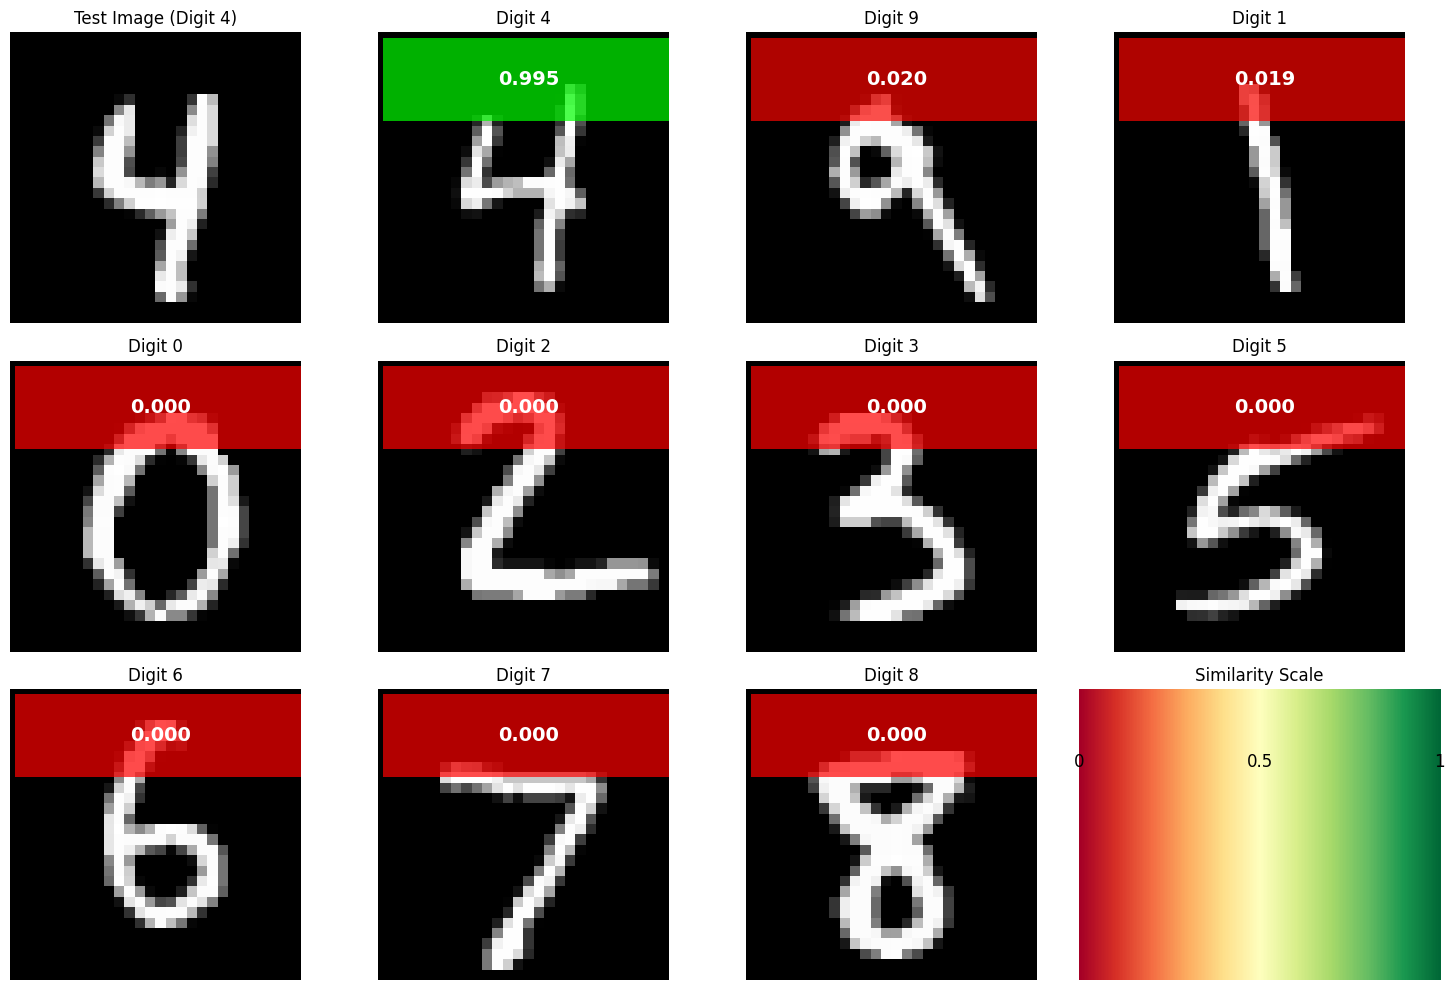

In [ ]:

# Try to load the saved model
try:
    model.load_state_dict(torch.load("best_model.pt", map_location=device, weights_only=True))
    print("Loaded saved model.")
except FileNotFoundError:
    print("No saved model found. Using untrained model for demonstration.")

model.eval()

def find_digit_examples(dataset, count_per_digit=5):
    examples = {i: [] for i in range(10)}

    for idx, (_, label) in enumerate(dataset):
        if len(examples[label]) < count_per_digit:
            examples[label].append(idx)

        # Break if we have enough examples of each digit
        if all(len(examples[i]) >= count_per_digit for i in range(10)):
            break

    return examples

# Find examples of each digit
digit_examples = find_digit_examples(test_dataset)

# Choose a random test image
def get_random_test_image():
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]
    orig_img = original_dataset[idx][0]
    return idx, img, label, orig_img

# Function to visualize similarity with scores displayed on the images
def visualize_similarity(model, test_idx, test_img, test_label, orig_img):
    test_img_tensor = test_img.unsqueeze(0).to(device)

    # Print header for the similarity scores
    print("\n" + "="*50)
    print(f"Similarity scores for test image (Digit {test_label}):")
    print("="*50)

    # Store results for plotting
    results = []

    # Compare with one example of each digit
    for digit in range(10):
        # Get an example of this digit
        n = random.randint(0,4)
        example_idx = digit_examples[digit][n]
        example_img, _ = test_dataset[example_idx]

        # Calculate similarity
        example_tensor = example_img.unsqueeze(0).to(device)
        with torch.no_grad():
            raw_sim = model.get_raw_similarity(test_img_tensor, example_tensor).item()
            logit = model(test_img_tensor, example_tensor).item()
            prob = torch.sigmoid(torch.tensor(logit)).item()

        # Print similarity score
        print(f"Similarity to digit {digit}: {raw_sim:.4f} (probability: {prob:.4f})")

        # Store results
        results.append((digit, example_idx, raw_sim, prob))

    # Sort results by similarity (highest to lowest)
    results.sort(key=lambda x: x[2], reverse=True)
    print("\nDigits ranked by similarity (highest to lowest):")
    for i, (digit, _, sim, prob) in enumerate(results):
        print(f"{i+1}. Digit {digit}: {sim:.4f} (probability: {prob:.4f})")

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Display the test image
    plt.subplot(3, 4, 1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Test Image (Digit {test_label})")
    plt.axis('off')

    # Define a color map for similarity scores
    def get_color(sim):
        """Return a color based on similarity score (green for high, red for low)"""
        sim = max(0.0, min(1.0, sim))  # Range is [0: 1]
        r = 1 - sim  # Red decreases as similarity increases
        g = sim      # Green increases with similarity
        b = 0.0
        return (r, g, b)

    # Plot all comparison images
    for i, (digit, example_idx, raw_sim, prob) in enumerate(results[:11]):  # Up to 11 comparisons
        orig_example = original_dataset[example_idx][0]

        # Plot the digit
        ax = plt.subplot(3, 4, i + 2)
        plt.imshow(orig_example, cmap='gray')

        # Add a colored similarity score box
        score_color = get_color(raw_sim)
        rect = Rectangle((0, 0), 28, 8, linewidth=0, facecolor=score_color, alpha=0.7)
        ax.add_patch(rect)

        # Add text with similarity score directly on the image
        plt.text(14, 4, f"{raw_sim:.3f}", color='white', fontsize=14,
                ha='center', va='center', fontweight='bold')

        # Special title for the "another example" case
        if i == 10 and digit == test_label:
            plt.title(f"Another {digit}")
        else:
            plt.title(f"Digit {digit}")

        plt.axis('off')

    # Add a colorbar to show the similarity scale
    plt.subplot(3, 4, 12)
    plt.axis('off')

    # Create a custom color bar
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    plt.imshow(gradient, aspect='auto', cmap=plt.cm.RdYlGn)
    plt.title("Similarity Scale")
    plt.text(0, 0, "0", fontsize=12, ha='center', va='center')
    plt.text(128, 0, "0.5", fontsize=12, ha='center', va='center')
    plt.text(255, 0, "1", fontsize=12, ha='center', va='center')

    plt.tight_layout()
    plt.savefig('digit_similarity_comparison.png')
    plt.show()

# Run the visualization
test_idx, test_img, test_label, orig_img = get_random_test_image()
print(f"Selected test image with label: {test_label}")
visualize_similarity(model, test_idx, test_img, test_label, orig_img)

# Function to test a specific digit
def visualize_specific_digit(digit):
    n = random.randint(0,4)
    if digit in range(10):
        test_idx = digit_examples[digit][n]
        test_img, test_label = test_dataset[test_idx]
        orig_img = original_dataset[test_idx][0]
        print(f"Showing similarity for digit: {digit}")
        visualize_similarity(model, test_idx, test_img, test_label, orig_img)
    else:
        print(f"Invalid digit: {digit}. Please choose a digit from 0-9.")


Showing similarity for digit: 2

Similarity scores for test image (Digit 2):
Similarity to digit 0: 0.0000 (probability: 0.0150)
Similarity to digit 1: 0.0000 (probability: 0.0150)
Similarity to digit 2: 1.0000 (probability: 0.9907)
Similarity to digit 3: 0.0000 (probability: 0.0150)
Similarity to digit 4: 0.0000 (probability: 0.0150)
Similarity to digit 5: 0.0000 (probability: 0.0150)
Similarity to digit 6: 0.0000 (probability: 0.0150)
Similarity to digit 7: 0.0000 (probability: 0.0150)
Similarity to digit 8: 0.0000 (probability: 0.0150)
Similarity to digit 9: 0.0000 (probability: 0.0150)

Digits ranked by similarity (highest to lowest):
1. Digit 2: 1.0000 (probability: 0.9907)
2. Digit 0: 0.0000 (probability: 0.0150)
3. Digit 1: 0.0000 (probability: 0.0150)
4. Digit 3: 0.0000 (probability: 0.0150)
5. Digit 4: 0.0000 (probability: 0.0150)
6. Digit 5: 0.0000 (probability: 0.0150)
7. Digit 6: 0.0000 (probability: 0.0150)
8. Digit 7: 0.0000 (probability: 0.0150)
9. Digit 8: 0.0000 (proba

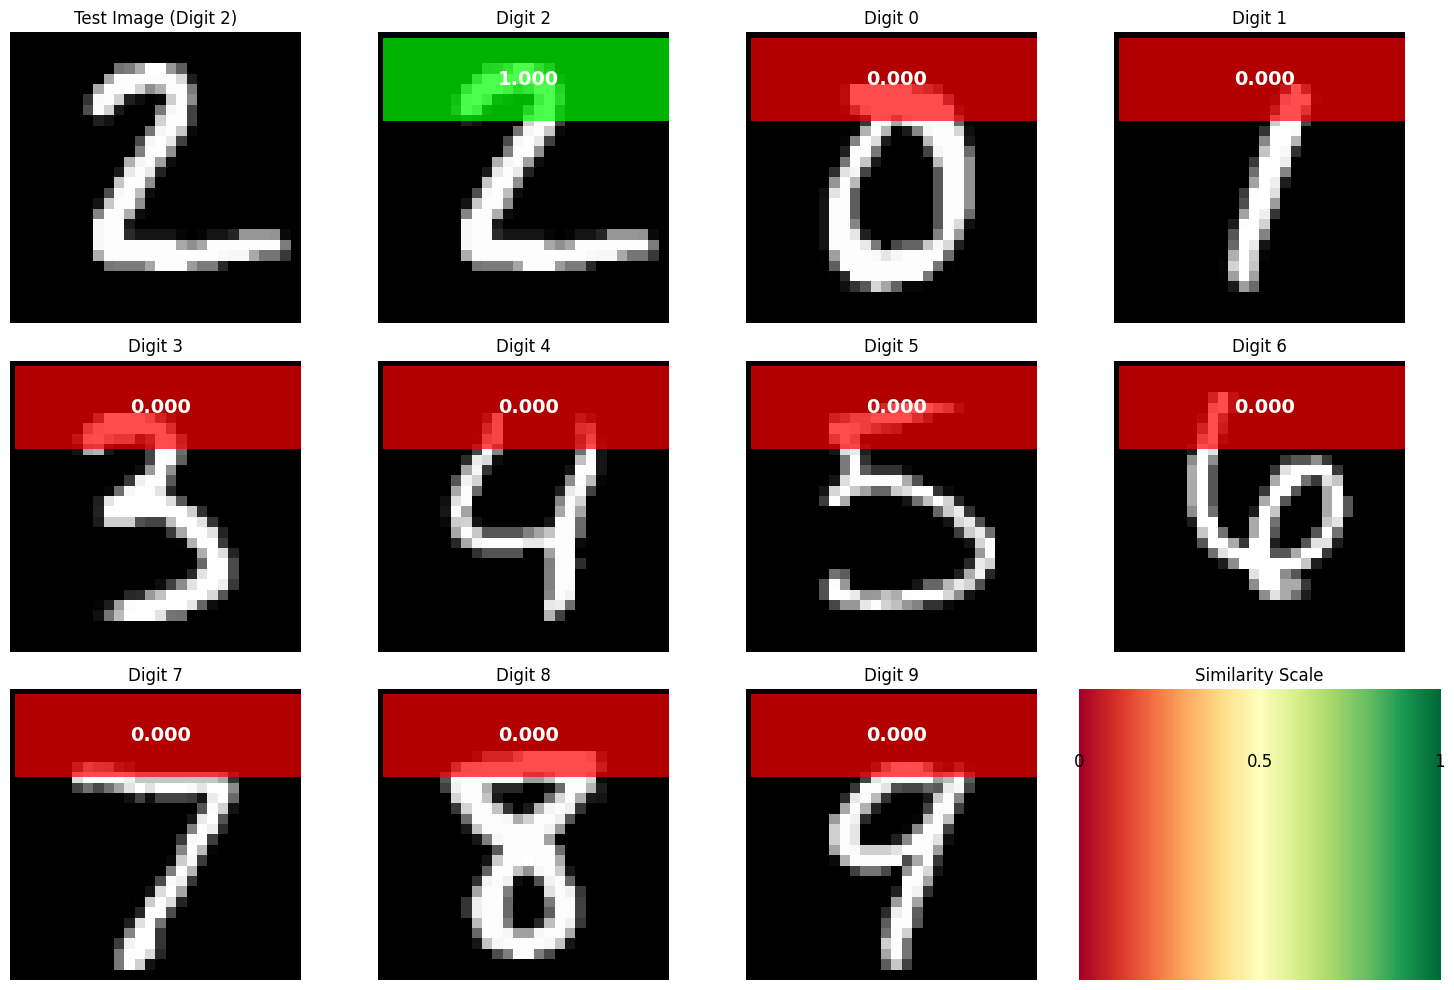

In [12]:
visualize_specific_digit(2)